# Brainlife analyses using Jupyter Notebooks and Python3

This example notebook will guide the user through grabbing data for their project from the secondary warehouse, compiling data across the entire project, and analyzing and visualizing the compiled results on brainlife.io via the 'Analysis' tab. This example is written for python3, and uses one of the Python3 notebook types.

Within this notebook, I will guide the user through analyses comprising derivatives generated from one of the three main datatypes available on brainlife.io, specifically neuro/anat/<t1, t2>. Specifically, I will guide the user through:
        
    1. Analyze the the quality of anatomical images using MRIQC
        
The functions provided in this notebook were designed for performing the many experiments provided in Wong et al (in prep), but should be a good starting point for you to get started on analyzing your project on brainlife.io!

### Important Note regarding assumptions of data structures, both inputs and outputs

Before we get started, it is important to note at the begging that the code in this notebook was designed mostly with a stereotypical data structure format in mind. For many of the datatypes, specifically the csv datatypes, follow the tidy format [https://www.jstatsoft.org/article/view/v059i10], where "each column is a variable, every row is an observation, and every cell is a singular value"[https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html]. There will be a few common columns, specifically 'subjectID' denoting the brainlife subject ID, 'sessionID' denoting the session ID on brainlife (will be 1 if there is no session ID data available), 'structureID' denoting the tissue structure of interest (ex. white matter tract, cortical parcel, eeg node), and 'nodeID' denoting the sample number of the structure. 'nodeID' is included across many .csv-based datatypes to conform with profilometry data, which has multiple samples or nodes per structure. For single measures of a given structure, the nodeID for all structures will be 1. 

I bring this up now to note that if you are not a fan of the style of the resulting data structures, or your data doesn't confirm to this style, you are free to alter this code to your deepest desires! I've attempted to do my best to comment and explain everything as much as possible for each section, function, and analysis. If there are any points where something is not working or you are not sure what the code is doing, feel free to email me at [bacaron@utexas.edu!]

# With that, let's get started!

## Install packages
The first things we need to do are to install some software packages using python's pip package manager, and then to load all of the necessary modules into our notebook.

We will also be loading some other packages, including matplotlib, seaborn, and nilearn for plotting, numpy for numerical calculations and array manipulations, itertools and scipy for statistical testing, pandas, json, and jgf for loading various datat strucutres, and scikit-learn's mean_squared_error function to compute root-mean-square-error for some of the final analyses.

Fortunately, all of the needed packages and scripts needed to perform analyses on brainlife have been packaged together into a single pypi python package: pybrainlife (https://github.com/brainlife/pybrainlife)!

## Importing packages
The first things we need to do is to load python packages in order to perform actions on the processed data, including matplotlib and seaborn for plotting, numpy for numerical calculations and array manipulations, itertools and scipy for statistical testing, pandas, and scikit-learn's mean_squared_error function to compute root-mean-square-error for some of the final analyses. 

We will load all of the functions we need by loading a few pybrainlife modules!

In [1]:
import os,sys
import random, string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pybrainlife.data.collect as blcollect
import pybrainlife.data.manipulate as blmanip
import pybrainlife.vis.plots as blplt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Generating subject demographic dataframe
Now that we've loaded all the functions needed, but before we get started collecting and analyzing our data, we first need to generate a subjects demographic database. This can include information stored in the participants.json file stored in the Project's Detail tab, but can also be user-generated. This is so we can then append that relevant information to each of the data structures we collect, compile, and generate for analysis. This makes it easier to build models and to perform statistical analyses with co-variates.

In the case of the Nigerian Brain Dataset, I will be grabbing the data directly from participant's info and will be doing some slight modifications.

Within this dataframe, I've also added a classID column corresponding to the project identification name (i.e. control, dementia, parkinsons) and a colors column corresponding to the color I assigned to each project (controls: orange, dementia: blue, parkinsons: green).

After this, I then created a color dictionary with a unique color for each participant in the project. This can make outlier detection a bit easier.

Finally, within this section we will also set up our data and image directories.

In [3]:
### setting up variables and adding paths
print("setting up variables")
topPath = "./"
os.chdir(topPath)
data_dir = topPath+'/data/'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
img_dir = topPath+'/img/'
if not os.path.exists(img_dir):
    os.mkdir(img_dir)

### grabbing subjects demographic data
print("grabbing demographic data")
if os.path.isfile(data_dir+'/subjects_data.csv'):
    subjects_data = pd.read_csv(data_dir+'/subjects_data.csv')
else:
    subjects_data = pd.read_json('input/participants.json')
print("grabbing demographic data complete")

# rename columns
subjects_data = subjects_data.rename(columns={'subject': 'subjectID','ClincalGroup': 'classID'})

# set subjectIDs as strings not int64
subjects_data['subjectID'] = [ str(f) for f in subjects_data['subjectID'] ]

# set up project identification (groups) and the project color
groups = subjects_data.classID.unique().tolist()
colors_array = ['blue','orange','green']
print("setting up variables complete")
subjects_data['colors'] = [ colors_array[groups.index(f)] for f in subjects_data['classID'] ]

## generate colors dictionary with a unique color for each subject
colors = {}
subjects = {}

# loop through groups and identify subjects and set color schema for each group
for g in range(len(groups)):
    # set subjects array
    subjects[groups[g]] =  subjects_data['subjectID']
    subjects[groups[g]].sort_values()
    
    # set colors array
    colors_name = colors_array[g]
    colors[groups[g]] = colors_array[g]

# # create subjects color dictionary
colors_dict = blcollect.create_color_dictionary(subjects_data,'subjectID','colorblind')

## here's what the subjects_data dataframe looks like!
subjects_data

setting up variables
grabbing demographic data
grabbing demographic data complete
setting up variables complete


,subjectID,sex,age,classID,SES,Education,GeopoliticalRegion,colors
0,1,F,15,Control,middle,secondary,South-South,blue
1,2,M,36,Control,middle,tertiary,South-South,blue
2,3,M,18,Control,middle,secondary,South-South,blue
3,4,M,49,Control,upper,tertiary,South-South,blue
4,5,M,41,Control,middle,secondary,South-South,blue
...,...,...,...,...,...,...,...,...
83,84,F,43,Parkinson,middle,secondary,South-South,green
84,85,M,79,Parkinson,lower,secondary,South-South,green
85,86,M,50,Parkinson,lower,tertiary,South-South,green
86,87,M,79,Parkinson,n/a,secondary,South-South,green


## Collecting statistical data of mriqc data
Now that we've generated our subjects dataframe, the next step is to collect, collate, and clean data pertaining to mriqc data. This data comes from the neuro/regressors datatype.

For this project, I specifically computed measures of quality of the T1w and T2w data using mriqc.

In [7]:
### mriqc
if os.path.isfile(data_dir+'/mriqc-results.csv'):
    mriqc_data = pd.read_csv(data_dir+'/mriqc-results.csv')
    mriqc_data['subjectID'] = [ str(f).zfill(2) for f in mriqc_data['subjectID'] ]
#     mriqc_data['ce'] = [ 'ce-gadolinium' if f == 'ce-gadlinium' else 'no-ce' if f == 'None' else f for f in mriqc_data['ce']]
else:
    # compile data and output the appropriate tags and datatype tags that we can append to our dataframe
    mriqc_data, mriqc_tags, mriqc_datatype_tags = blcollect.collect_data('neuro/regressors',['mriqc'],[],'regressors.tsv',data_dir+'/mriqc-results.csv',False)
    
    # some simple cleanup
    mriqc_data = mriqc_data.drop(columns='modality')
    mriqc_data = mriqc_data.rename(columns={'bids_meta': 'modality'})

    # append tags and datatype tags, and create a new column for whether the data is contrast enhanced or not
    mriqc_data['tags'] = mriqc_tags
    mriqc_data['datatype_tags'] = mriqc_datatype_tags
    mriqc_data['ce'] = [ [ i for i in str(f).strip('][').split(', ') if 'ce' in i][0].strip("''") if 'ce' in str(f) else 'None' for f in mriqc_data['tags'] ]
    mriqc_data['ce'] = [ 'ce-gadolinium' if f == 'ce-gadlinium' else 'no-ce' if f == None else f for f in mriqc_data['ce']]
    mriqc_data['ce'] = [ 'ce-gadolinium' if f == 'ce-gadlinium' else 'no-ce' if f == 'None' else f for f in mriqc_data['ce']]
    mriqc_data['acq_orientation'] = [ [ i for i in str(f).strip('][').split(', ') if 'acq' in i][0].strip("''") if 'acq' in str(f) else 'None' for f in mriqc_data['tags'] ]
    mriqc_data['run'] = [ 'no-run' if f == str(1) else f for f in mriqc_data['sessionID'] ]

    # sort dataframe by subjectID
    mriqc_data = mriqc_data.sort_values(by='subjectID')
    
    # reset the index
    mriqc_data = mriqc_data.reset_index(drop=True)
    
    # drop duplicates
    mriqc_data.drop_duplicates(subset={'subjectID','modality','run','ce','acq_orientation'})

    # merge subjects_data
    mriqc_data = pd.merge(mriqc_data,subjects_data,on='subjectID')

    # output to a csv
    mriqc_data.to_csv(data_dir+'/mriqc-results.csv',index=False)

# view dataframe
mriqc_data

,modality,cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,icvs_csf,...,tpm_overlap_wm,wm2max,subjectID,sessionID,tags,datatype_tags,finish_dates,ce,acq_orientation,run
0,T1w,0.503465,2.869423,0.509634,91346.666860,4.004077,4.615882,5.837534,1.558814,0.163603,...,0.374128,0.478018,01,1,"['acq-axial', 'no-ce']","['mriqc', 't1']",2024-05-13T11:32:56.491Z,no-ce,acq-axial,no-run
1,T1w,0.494015,2.981418,0.516600,94477.195102,3.565799,4.089562,5.059593,1.548242,0.139011,...,0.361747,0.462630,01,1,"['acq-axial', 'ce-gadolinium']","['mriqc', 't1']",2024-05-12T13:48:37.078Z,ce-gadolinium,acq-axial,no-run
2,T1w,0.507344,2.753008,0.626073,8338.271456,5.376635,1.507533,7.234824,7.387549,0.154756,...,0.433042,0.415804,01,1,"['acq-sagittal', 'ce-gadolinium']","['mriqc', 't1']",2024-05-12T13:57:40.095Z,ce-gadolinium,acq-sagittal,no-run
3,T1w,0.545688,2.148875,0.548557,10570.924225,6.463513,8.144463,1.863137,9.382939,0.166345,...,0.442427,0.436441,01,1,"['no-ce', 'acq-coronal']","['mriqc', 't1']",2024-05-12T13:00:52.144Z,no-ce,acq-coronal,no-run
4,T1w,0.562274,2.128032,0.521723,19468.337797,5.764225,7.205141,1.745700,8.341834,0.146619,...,0.417528,0.398348,01,1,"['acq-coronal', 'ce-gadolinium']","['mriqc', 't1']",2024-05-12T13:00:50.549Z,ce-gadolinium,acq-coronal,no-run
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,T1w,0.451988,2.953953,0.541447,11528.287484,6.549932,1.753989,10.816345,7.079461,0.215633,...,0.493618,0.382703,88,1,"['no-ce', 'acq-sagittal']","['mriqc', 't1']",2024-05-12T13:02:33.175Z,no-ce,acq-sagittal,no-run
581,T1w,0.466541,2.893340,0.504374,-1.000000,3.363467,4.080074,4.352160,1.658166,0.202772,...,0.493556,0.361039,88,1,"['acq-axial', 'ce-gadolinium']","['mriqc', 't1']",2024-05-12T12:58:30.576Z,ce-gadolinium,acq-axial,no-run
582,T2w,0.809027,1.193267,0.564930,2315.411355,3.975150,1.216194,5.992143,4.717113,0.270556,...,0.452090,0.274794,88,1,['acq-sagittal'],"['mriqc', 't2']",2024-05-12T12:10:37.673Z,no-ce,acq-sagittal,no-run
583,T2w,0.784598,1.167967,0.558275,7838.979515,3.794963,5.077514,5.051710,1.255666,0.290605,...,0.449417,0.277503,88,1,['acq-axial'],"['mriqc', 't2']",2024-05-12T12:10:32.245Z,no-ce,acq-axial,no-run


## Analyzing contrast-to-noise ratio
Now that we have the data collected and collated, the next step is to analyze some of the quality assurance measures. For now, let's look at the contrast-to-noise ratio (CNR) for each modality (T1w, T2w) and orientation (axial, sagittal, coronal).

For this, we will use some plotting functionality from seaborn!

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


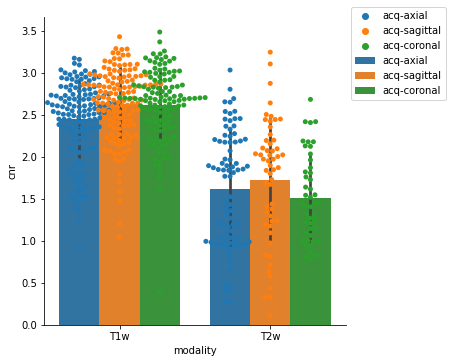

In [26]:
sns.catplot(x='modality',y='cnr',data=mriqc_data,hue='acq_orientation', kind="bar", errorbar='sd',legend=False,order=['T1w','T2w'])
sns.swarmplot(x='modality',y='cnr',data=mriqc_data,hue='acq_orientation',dodge=True, order=['T1w','T2w'])
ax = plt.gca()
ax.legend(bbox_to_anchor=(1, 1.05))
plt.savefig(f'{img_dir}/cnr.eps',dpi=1000,format='eps')